#Estymacja liczby głosów na podstawie cech gry planszowej
##T. Jastrzębski, I. Piotrowiak


In [22]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model  import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import seaborn as sns

data = pd.read_csv('/content/bg_info.csv')
data_orginal=data.copy()

# 1. Analiza stopnia wypełnienia danych

In [23]:
print("Liczba danych: " + str(data.shape[0]))
print("Liczba cech: " + str(data.shape[1]))
data.info()

Liczba danych: 25339
Liczba cech: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25339 entries, 0 to 25338
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          25339 non-null  object 
 1   Geek Rating    25339 non-null  float64
 2   Avg rating     25339 non-null  float64
 3   Num of voters  25339 non-null  int64  
 4   Price          4150 non-null   float64
 5   Year           25113 non-null  float64
 6   Complexity     25339 non-null  float64
 7   Min players    25298 non-null  float64
 8   Max players    25298 non-null  float64
 9   Min time       24513 non-null  float64
 10  Max time       24513 non-null  float64
 11  Age            23841 non-null  float64
 12  Type 1         13327 non-null  object 
 13  Type 2         1828 non-null   object 
dtypes: float64(10), int64(1), object(3)
memory usage: 2.7+ MB


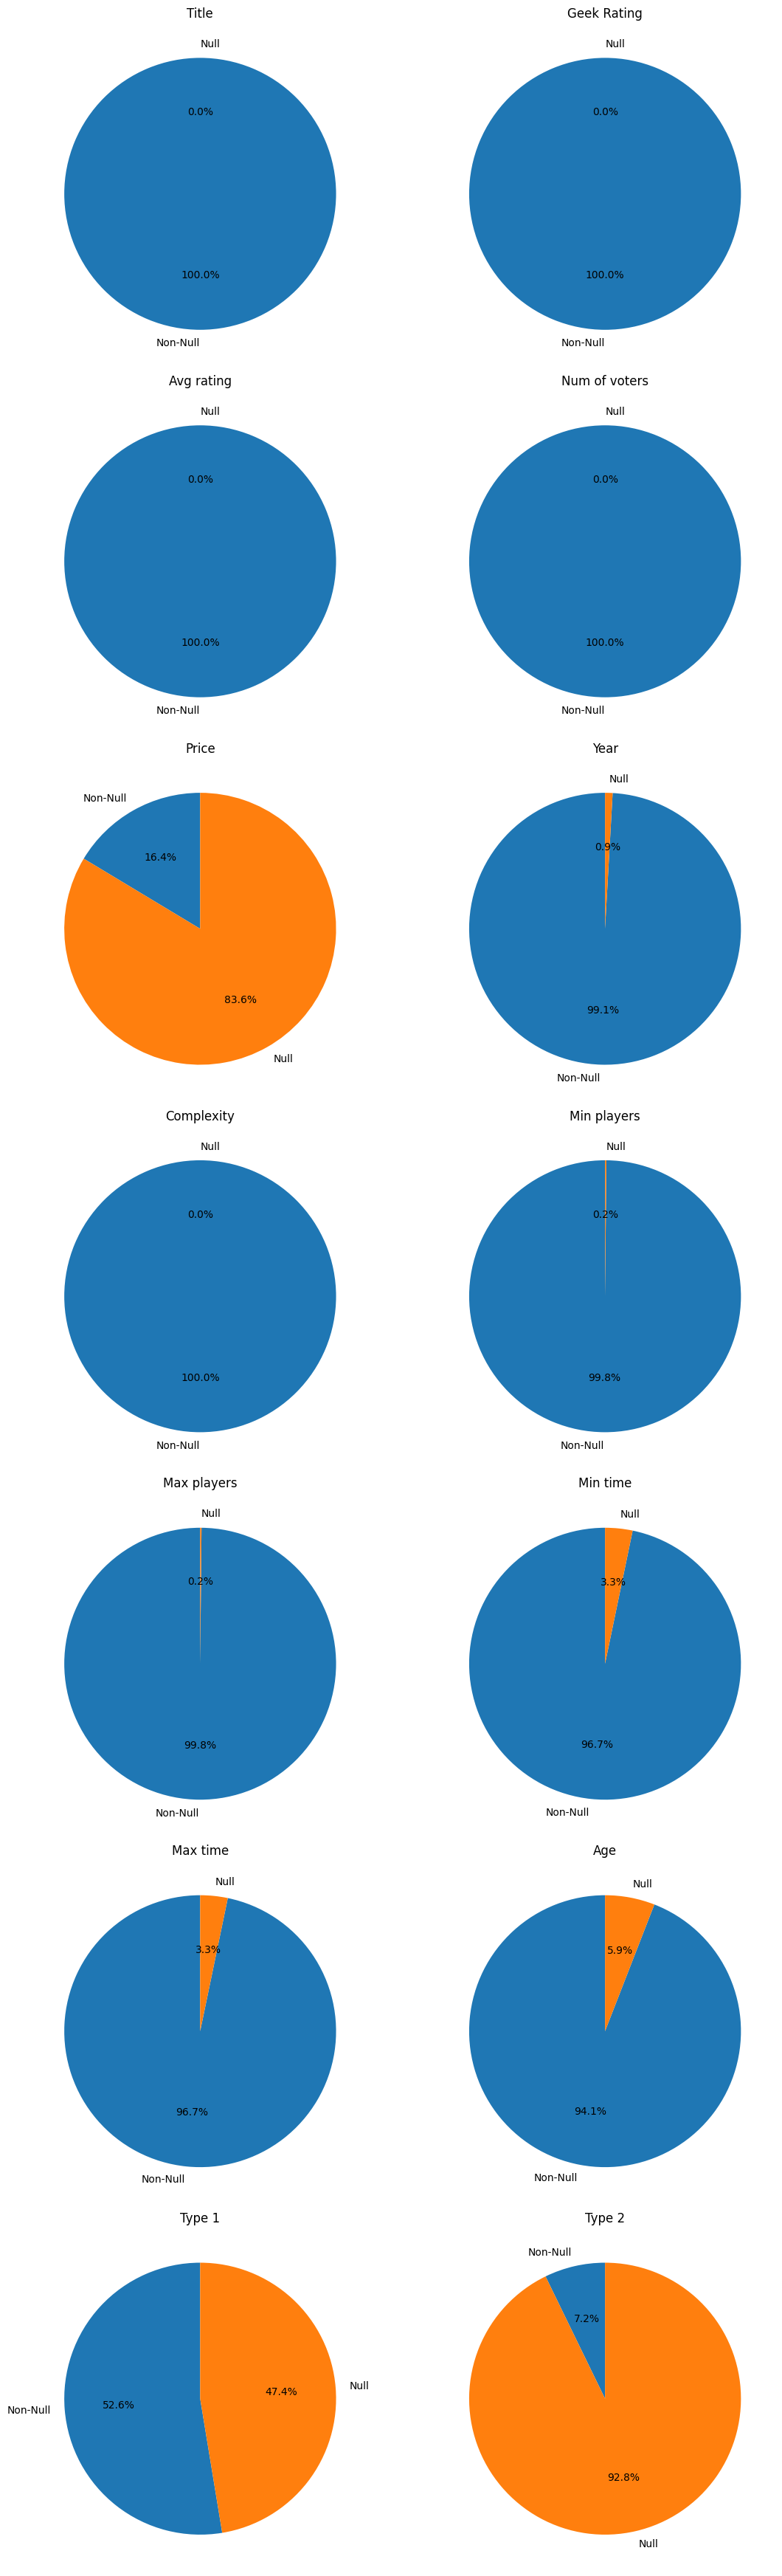

In [24]:
non_null_ratios = data.notnull().sum() / data.shape[0]

num_columns = 2
num_rows = (len(data.columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    non_null_count = non_null_ratios[column]
    null_count = 1 - non_null_count
    counts = [non_null_count, null_count]
    labels = ['Non-Null', 'Null']

    axes[i].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"{column}")

for j in range(len(data.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Zbiór składa sie z 25339 gier opisanych przez 14 cech, wliczając tytuł. Wszystkie gry mają w pełni uzupełnioną zmienną objaśnianą "Num of voters". W pełni uzupełnione też są kolumny: "Geek Rating", "Avg rating" oraz "Complexity". Niewielkie braki znajdują się w kolumnach: "Age", "Max time", "Min time", "Max players" i "Min players". Duże braki znajdują sie w kolumnie "Price" oraz w kolumnach "Type 1" i Type 2", które opisują kategorie gry.

In [25]:
rows_with_condition = data[(data['Type 1'].isnull()) & (data['Type 2'].notnull())]

print(len(rows_with_condition))

0


Do dalszej analizy zbioru zdecydowaliśmy się na odrzucenie cechy "price" z powodu dużych braków. Ponadto dla uproszeczenia modelu odrzuciliśmy cechę "Type 2" zakładając, że gdy gra ma dwie przypisane kategorie to "Type 1" zawiera tą ważniejszą, zwłaszcza że nie ma rekordów gdzie "Type 2" występowałoby bez "type 1", co udowadnia powyższy kod. Po odrzuceniu tych dwóch cech, odrzuciliśmy wiersze zawierające braki, ignorując braki w kolumnie "Type 1". Decyzję taką podjeliśmy, kierując się logiką, że w tym przypadku brak danej, to też jakaś dana.

In [26]:
data = data.drop(columns = ['Type 2', 'Price'])
data = data.loc[data.drop(columns=['Type 1']).notnull().all(axis=1)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23136 entries, 0 to 25338
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          23136 non-null  object 
 1   Geek Rating    23136 non-null  float64
 2   Avg rating     23136 non-null  float64
 3   Num of voters  23136 non-null  int64  
 4   Year           23136 non-null  float64
 5   Complexity     23136 non-null  float64
 6   Min players    23136 non-null  float64
 7   Max players    23136 non-null  float64
 8   Min time       23136 non-null  float64
 9   Max time       23136 non-null  float64
 10  Age            23136 non-null  float64
 11  Type 1         12181 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 2.3+ MB


# 2. Zbadanie zakresów i stopnia zmienności

In [27]:
data.describe()

,Geek Rating,Avg rating,Num of voters,Year,Complexity,Min players,Max players,Min time,Max time,Age
count,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000
mean,5.690122,6.472432,989.478864,2006.442643,1.950482,1.979815,5.929936,59.682659,91.973288,10.302256
std,0.363895,0.892705,4212.881500,80.786815,0.822186,0.700723,15.236176,414.892863,737.473240,2.805251
min,5.348000,1.300000,30.000000,-3500.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.511000,5.910000,60.000000,2004.000000,1.290000,2.000000,4.000000,20.000000,30.000000,8.000000
50%,5.545000,6.490000,137.000000,2014.000000,1.880000,2.000000,4.000000,30.000000,45.000000,10.000000
75%,5.679000,7.070000,448.000000,2018.000000,2.500000,2.000000,6.000000,60.000000,90.000000,12.000000
max,8.421000,9.760000,123256.000000,2025.000000,5.000000,10.000000,999.000000,60000.000000,84000.000000,21.000000


Jak widać na powyższym opisie, wiele cech charakteryzuje się dość dużą rozpiętością zmiennych, zwłaszcza tych o największej wartości. Cechą, która najbardziej się wyróżnia jest 'Max time' - trzeci kwartyl tej cechy stanowi zaledwie promil jej maksymalnej wartości. Innymi cechami, które mają niesamowicie duży rozrzut są 'Min time', 'Max players' oraz 'Num of voters'. Największy zakres zmienności ma 'Num of voters'. Poniżej znajduje się wizualizacja rokładu za pomocą wykresów skrzypcowych i pudełkowych.

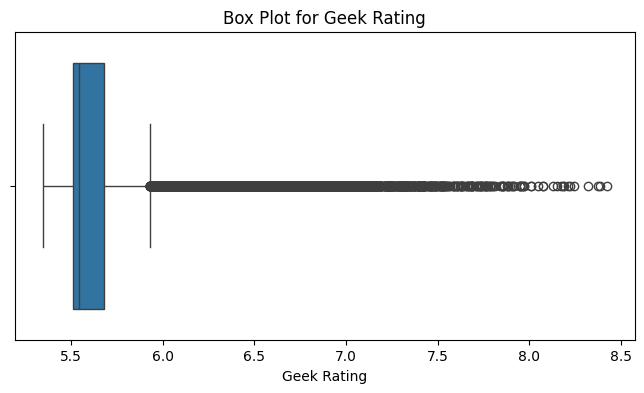

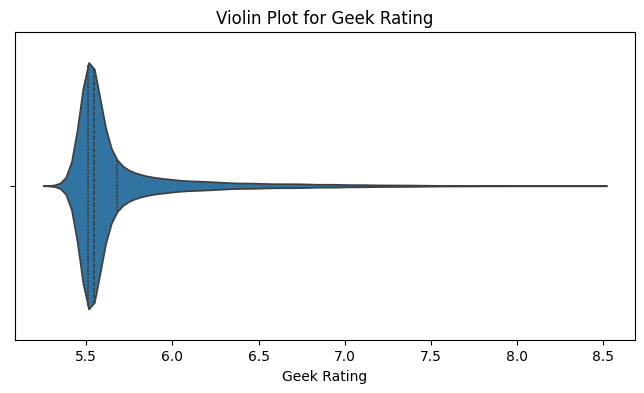

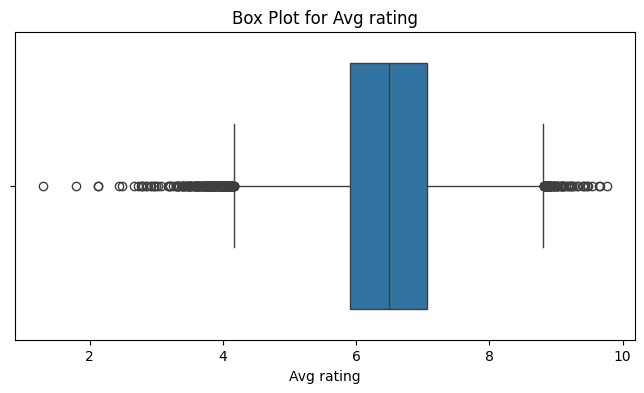

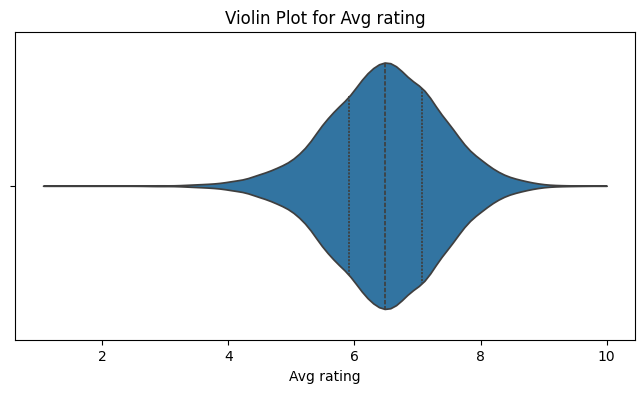

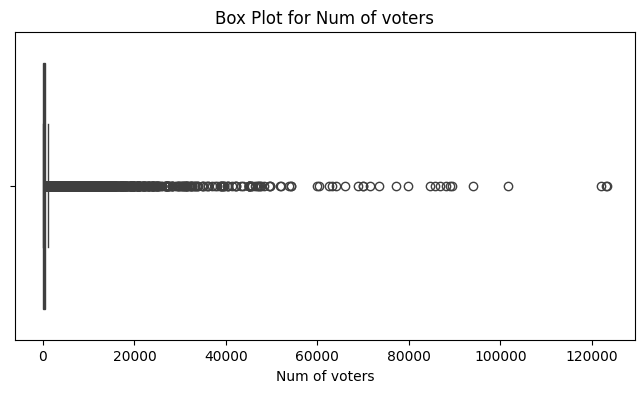

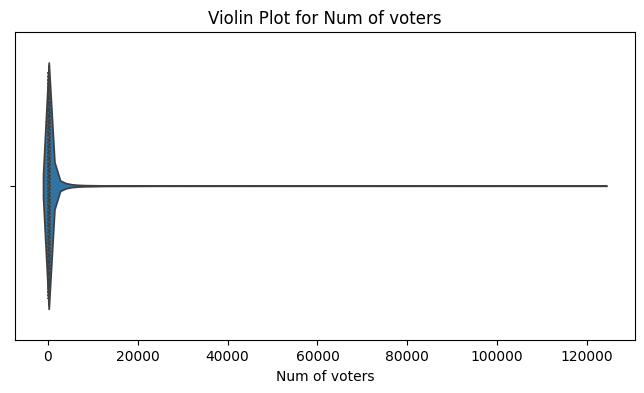

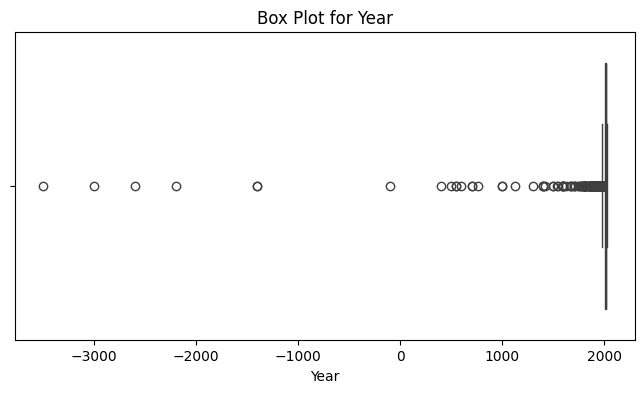

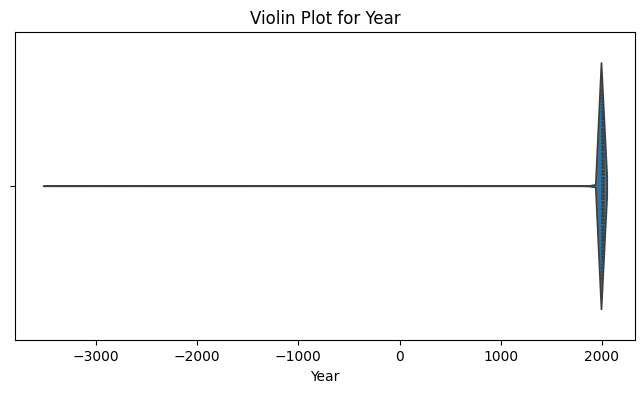

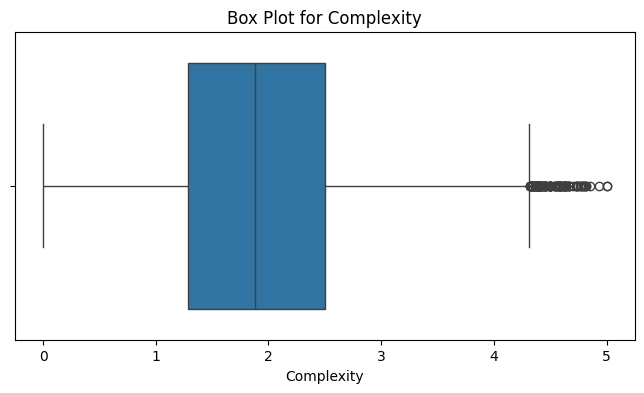

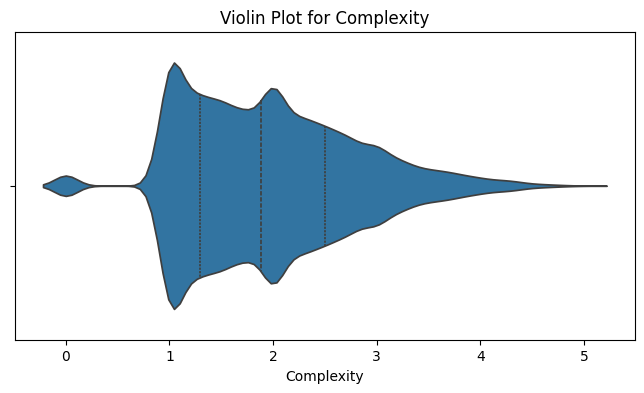

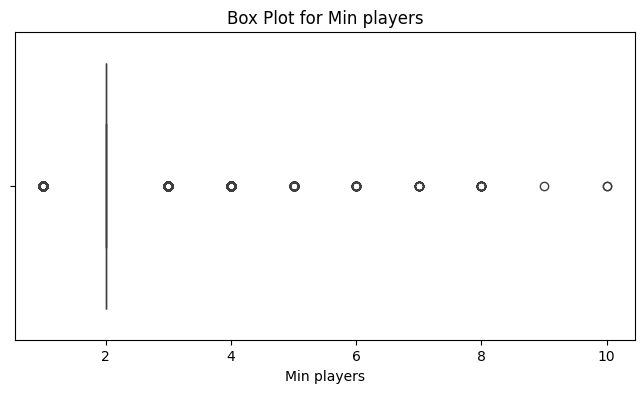

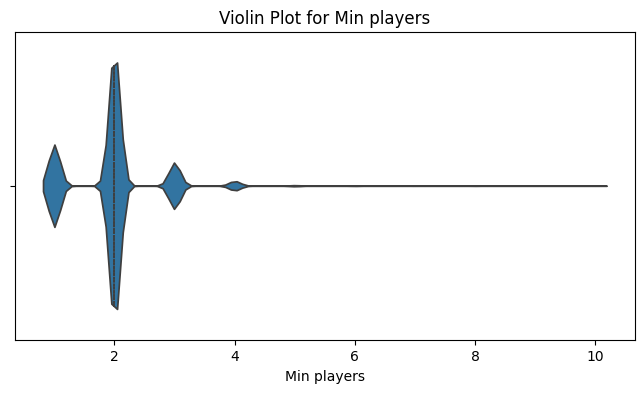

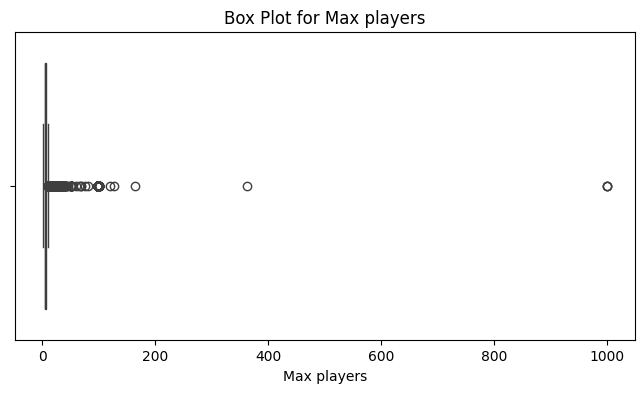

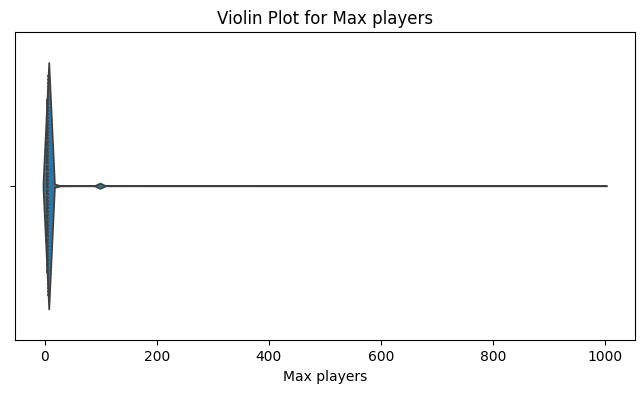

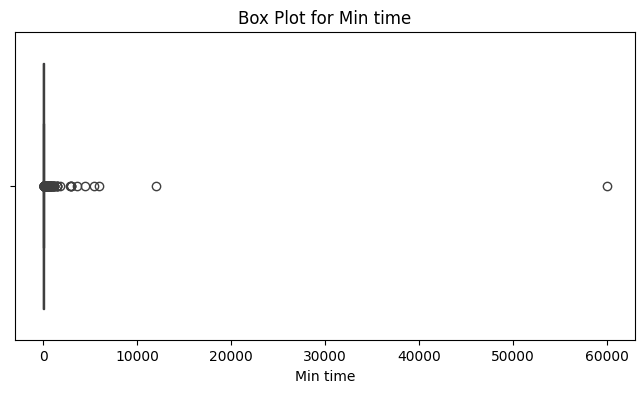

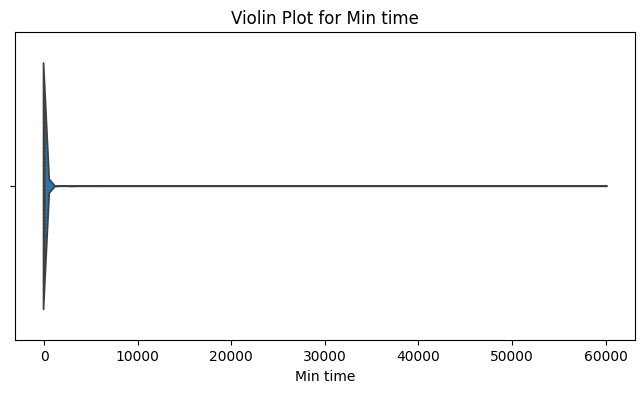

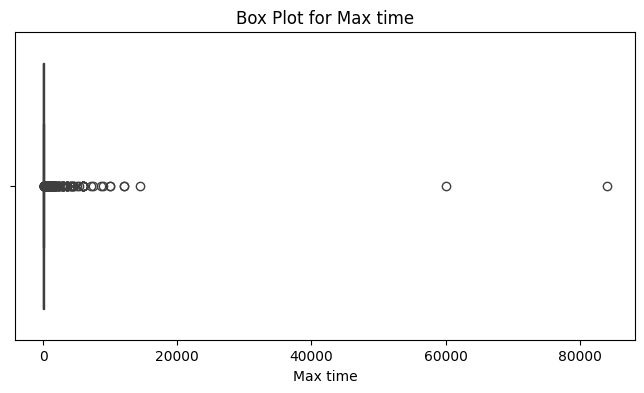

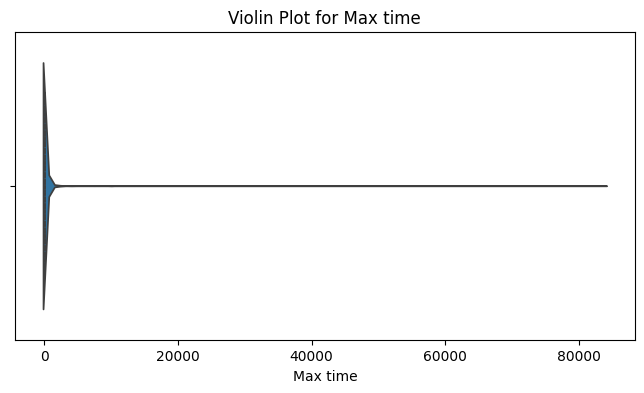

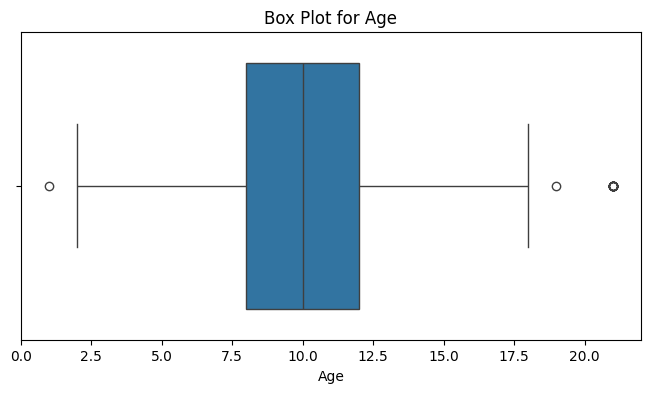

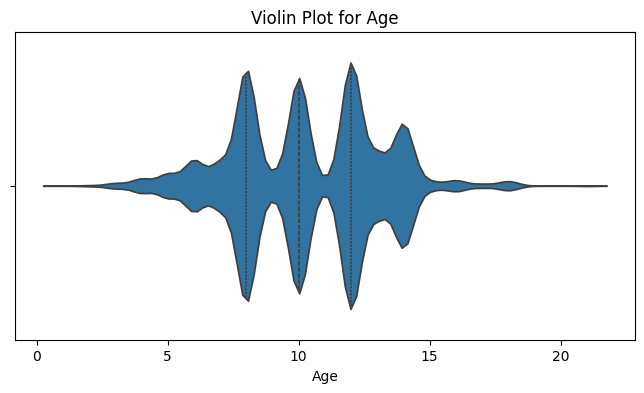

In [28]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot dla {col}')
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.violinplot(x=data[col], inner='quartile')
    plt.title(f'Violin Plot dla {col}')
    plt.show()

Aby kolejność odrzucania kolumn nie wpływała na wyniki odrzucenia wartości odstajacych dodaliśmy roboczą kolumnę "toRemove", która przechowuje informacje czy wartość jakiejkolwiek cechy w danym wierszu została uznana za odstającą.

Poniżej wyświetlamy histogramy dla każdej z cech numerycznych. Celem tego jest dobranie najlepszej metody selekcji automatycznej dla każdej z cech.

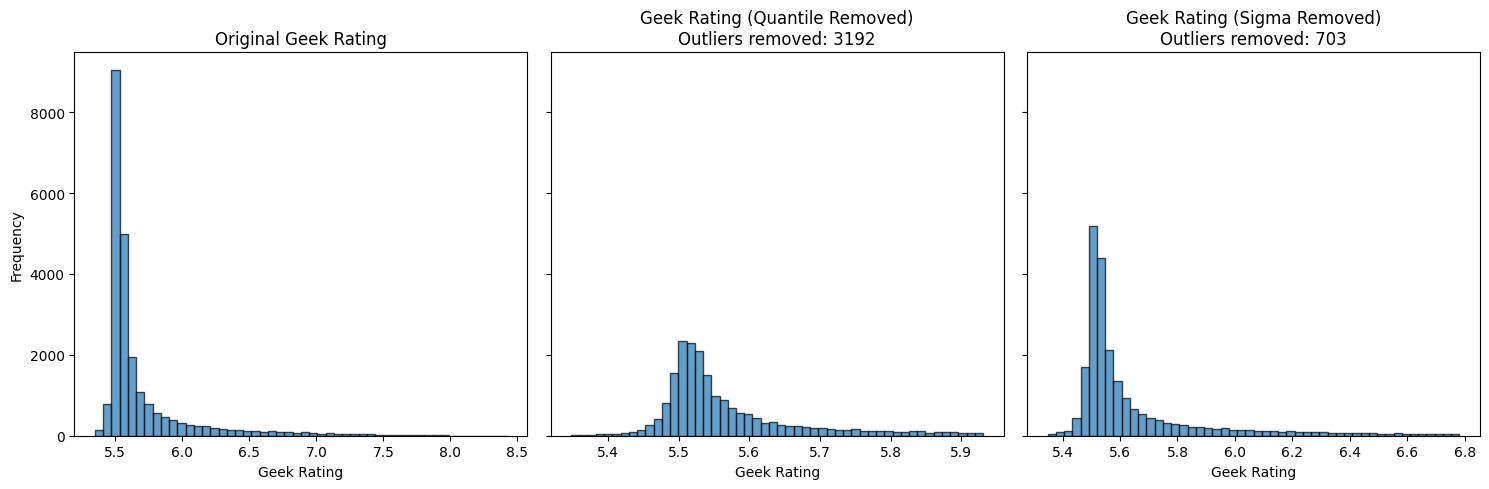

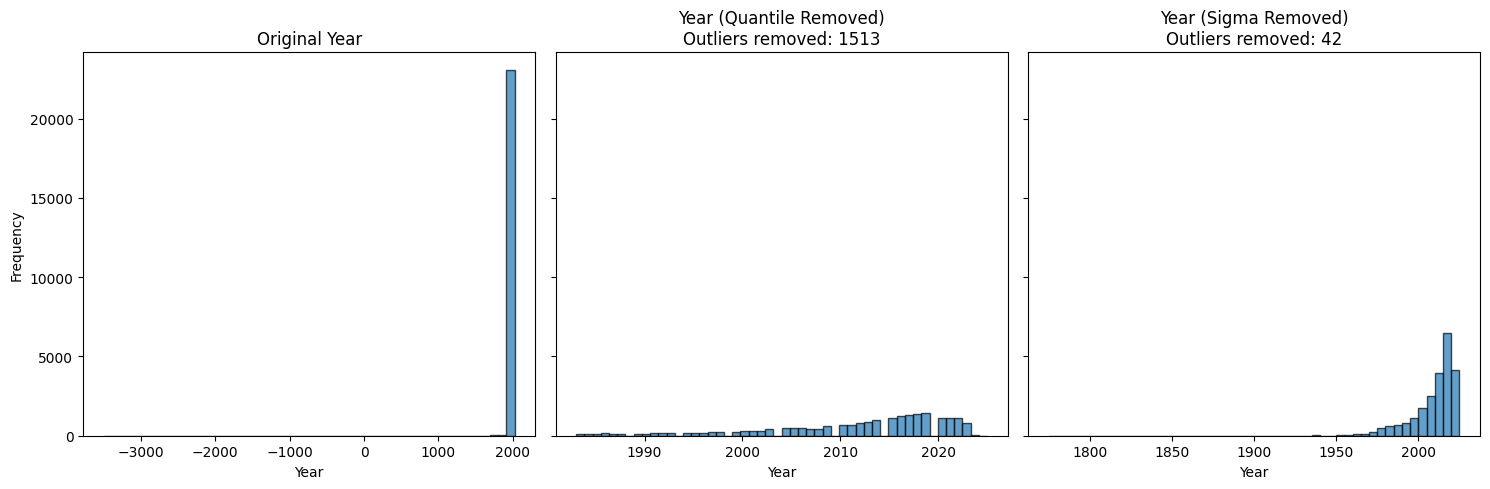

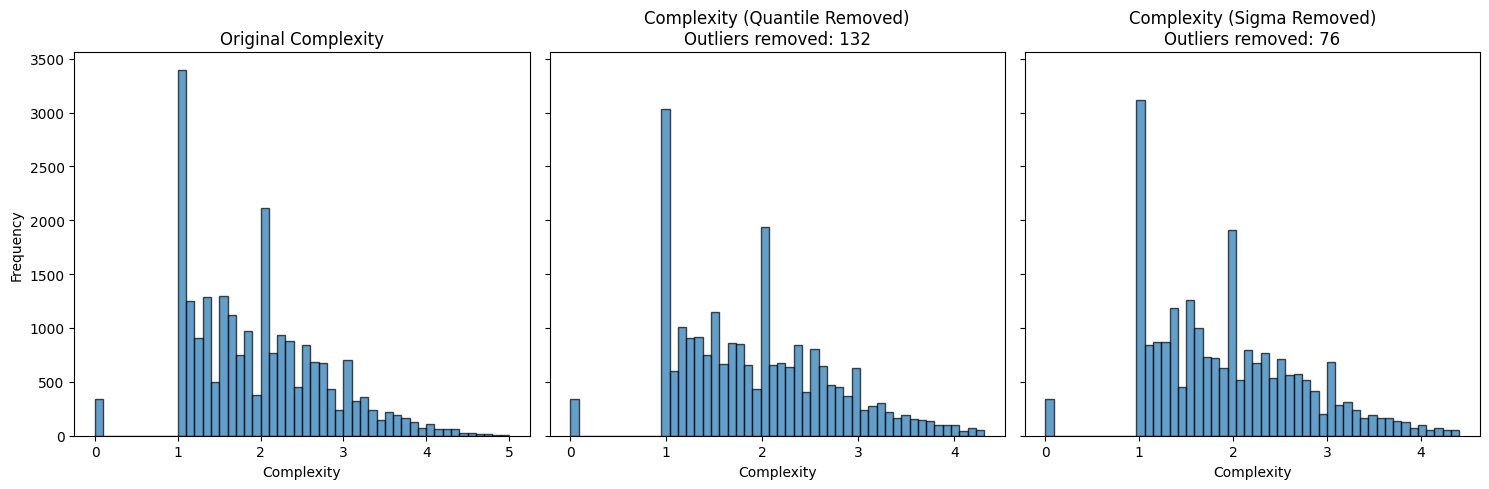

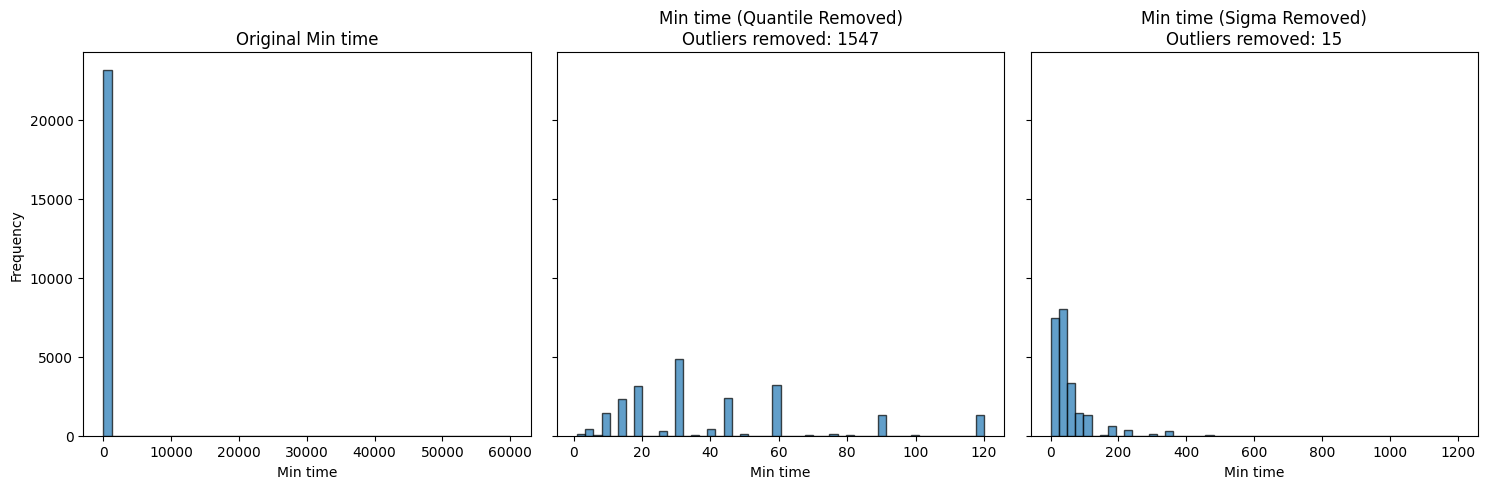

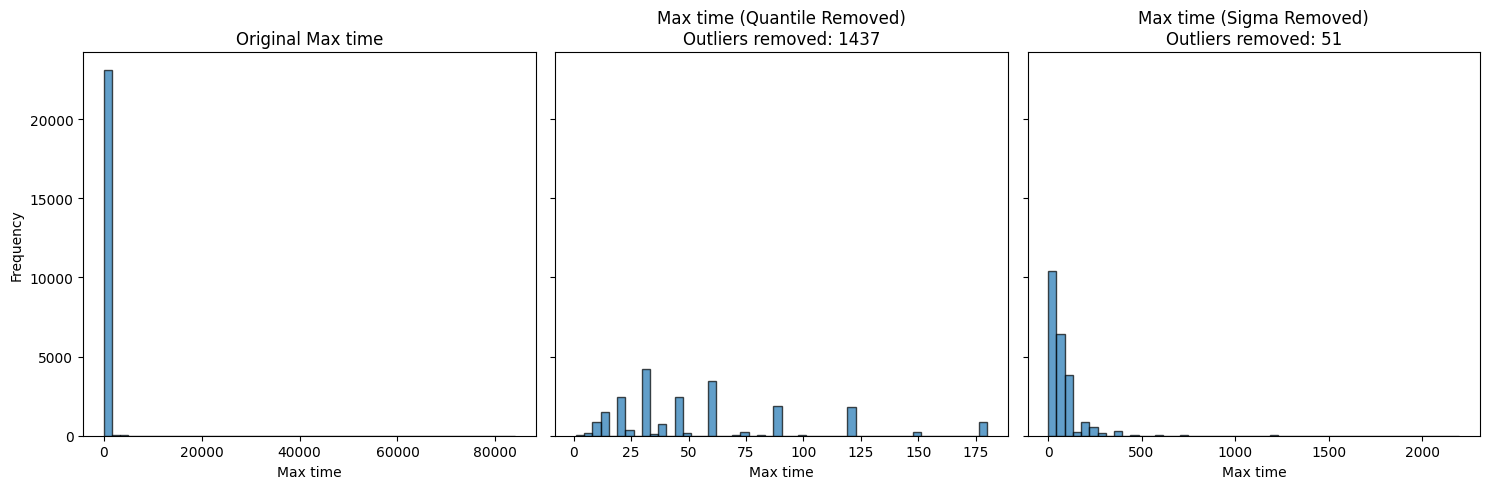

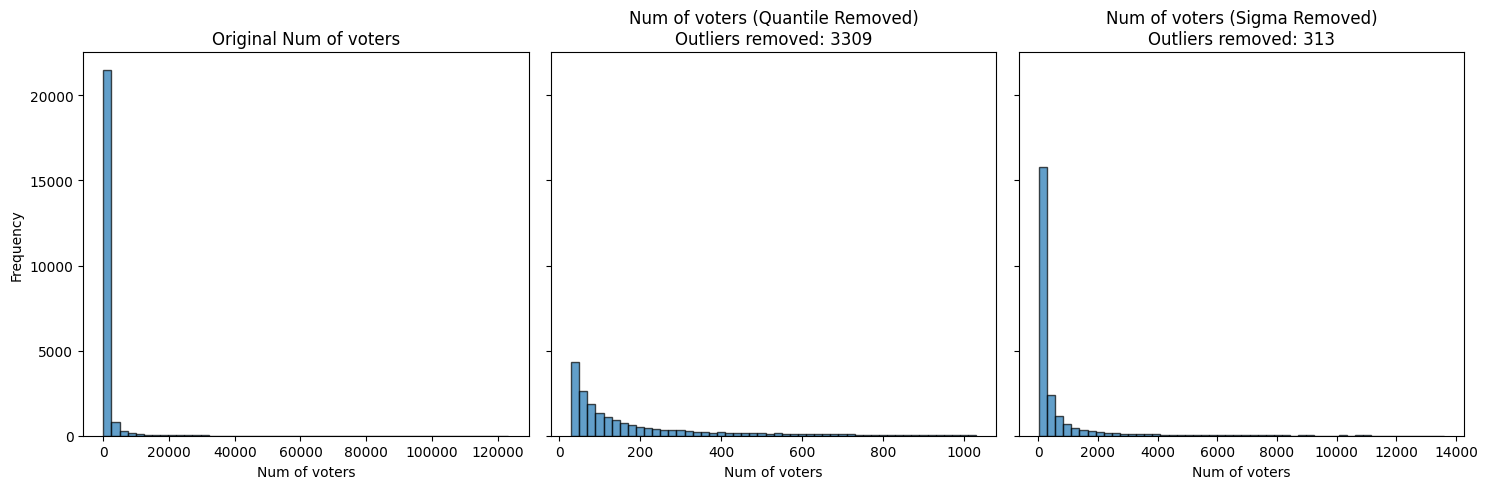

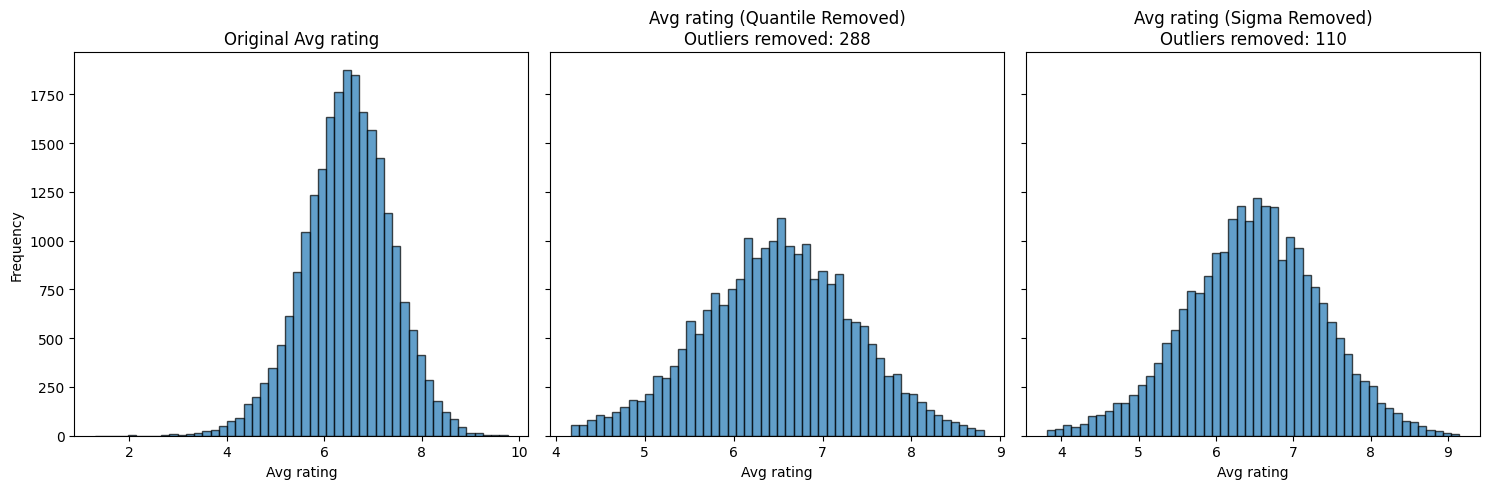

In [29]:
data['ToRemove'] = False

def mark_outliers_quantile(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), 'ToRemove'] = True

def mark_outliers_sigma(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), 'ToRemove'] = True

all_columns_with_outliners_to_drop = ['Geek Rating', 'Year', 'Complexity', 'Min time', 'Max time', 'Num of voters', 'Avg rating']

for col in all_columns_with_outliners_to_drop:
    original_data = data[col]

    data['ToRemove'] = False
    mark_outliers_quantile(data, col)
    quantile_removed_data = data[data['ToRemove'] == False][col]
    quantile_outliers_count = data['ToRemove'].sum()

    data['ToRemove'] = False
    mark_outliers_sigma(data, col)
    sigma_removed_data = data[data['ToRemove'] == False][col]
    sigma_outliers_count = data['ToRemove'].sum()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    axes[0].hist(original_data, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Original {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    axes[1].hist(quantile_removed_data, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'{col} (Quantile Removed)\nOutliers removed: {quantile_outliers_count}')
    axes[1].set_xlabel(col)

    axes[2].hist(sigma_removed_data, bins=50, edgecolor='black', alpha=0.7)
    axes[2].set_title(f'{col} (Sigma Removed)\nOutliers removed: {sigma_outliers_count}')
    axes[2].set_xlabel(col)

    plt.tight_layout()
    plt.show()


W celu odrzucenia wartości skrajnych zdecydowaliśmy się na zastosowanie dwóch metod automatycznych oraz metody wyboru ręcznego, których wybór zależy od kształtu wykresu każdej z cech oraz jej zakresu zmienności. Można zauważyć, że użycie odchylenia standardowego odrzuca mniej rekordów niż użycie metody rozstępu międzykwartylowego.

Wykresy cech 'Geek Rating', 'Complexity' i 'Avg rating' przypominają rozkład normalny bądź rozkład prawo- lub lewoskośny. Dodatkowo, ich zakres zmienności jest zbliżony po użyciu metody rozstępu międzykwartylowego i użyciu odchylenia standardowego. By odrzucić możliwie najminiejszą ilość przydatnych danych, zdecydowaliśmy się na użycie metody odchylenia standardowego. Swoisty wyjątek stanowi cecha 'Num of voters', niemniej zdecydowaliśmy się na użycie odchylenia standardowego w jej przypadku, ponieważ chcieliśmy zachować dużą część rekordów o wyższych wartościach, będących popularniejszymi grami.

Cechy 'Min time' oraz 'Max time' charakteryzują się ogromną rozpiętością z jednocześnie niewielką liczbą rekordów dla wyższych wartości. Na podstawie kształów ich wykresów zdecydowaliśmy, że użycie metody odchylenia standardowego byłoby dla nich błędem i jednocześnie zachowałoby wiele danych potencjalnie odstających. W związku z tym, postanowiliśmy je potraktować metodą rozkłądu międzykwartylowego.

Dla kolumny 'Year' zastosowaliśmy ręczne odrzucenie obserwacji skrajnych. Jako punkt podziału wybraliśmy rok 1950, uznając że analizujemy tylko gry współczesne (może być to istotne z perspektywy biznesowej).


In [30]:
quantile_columns = ['Min time', 'Max time']
sigma_columns = ['Geek Rating',  'Complexity', 'Avg rating', 'Num of voters']

for col in quantile_columns:
    mark_outliers_quantile(data, col)

for col in sigma_columns:
    mark_outliers_sigma(data, col)

data = data[data['ToRemove'] == False]
data = data.drop(columns=['ToRemove'])
data = data[data['Year'] >= 1950]

Ponadto na histogramach zauważylismy anomalię występującą w kolumnie Complexity. Wartości od 1 do 5 są ciągłe, ale pojawia się odstająca wartość 0,0. Prawdopodobnie jest to wynik uzupełnienia danych brakujących. Zgodnie z założeniami z punktu pierwszego, wiersze z brakami odrzucamy, więc podobnie podchodzimy do wierszy gdzie Complexity = 0.0. Poza tym, zaobserwowaliśmy szereg gier z datą wydanie 2025. Spodziewając się błędów dla jeszcze nieopublikowanych gier, postanowiliśmy o ich odrzuceniu.

In [31]:
data = data[data['Complexity'] != 0.0]
data = data[data['Year'] < 2025]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, 706 to 25338
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          19869 non-null  object 
 1   Geek Rating    19869 non-null  float64
 2   Avg rating     19869 non-null  float64
 3   Num of voters  19869 non-null  int64  
 4   Year           19869 non-null  float64
 5   Complexity     19869 non-null  float64
 6   Min players    19869 non-null  float64
 7   Max players    19869 non-null  float64
 8   Min time       19869 non-null  float64
 9   Max time       19869 non-null  float64
 10  Age            19869 non-null  float64
 11  Type 1         9540 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 2.0+ MB
None


Dla atrybutów "Max players", "Min players" i "Age" zdecydowaliśmy się na zamienie ich z ilościowych na atrybuty kategoryczne porządkowe. Wynika to z faktu, że ich wartością są wyłącznie liczbami naturalnymi i że same cechy przyjmują stosunkowo niewiele wartości unikalnych. Histogramy dla tych cech prezentują się w następujący sposób:

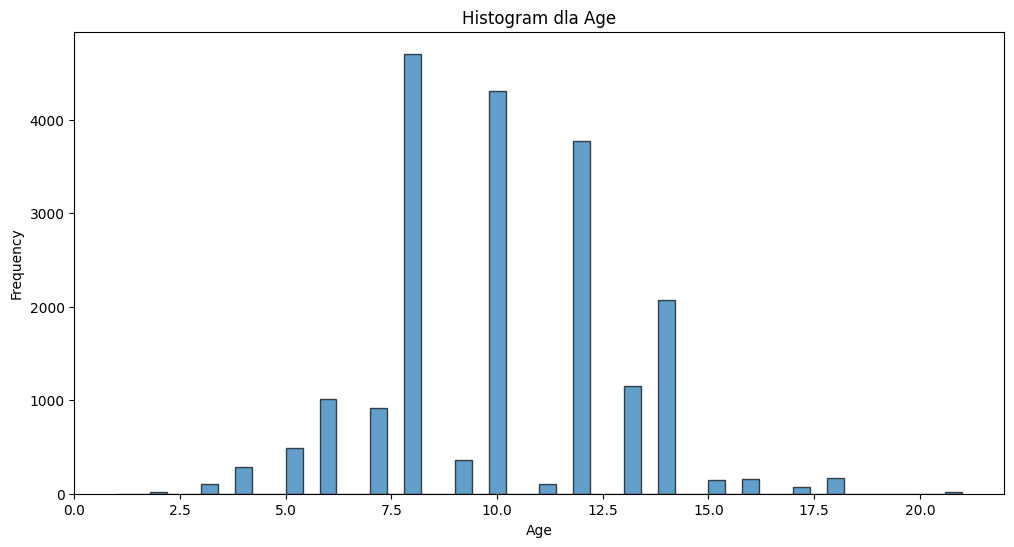

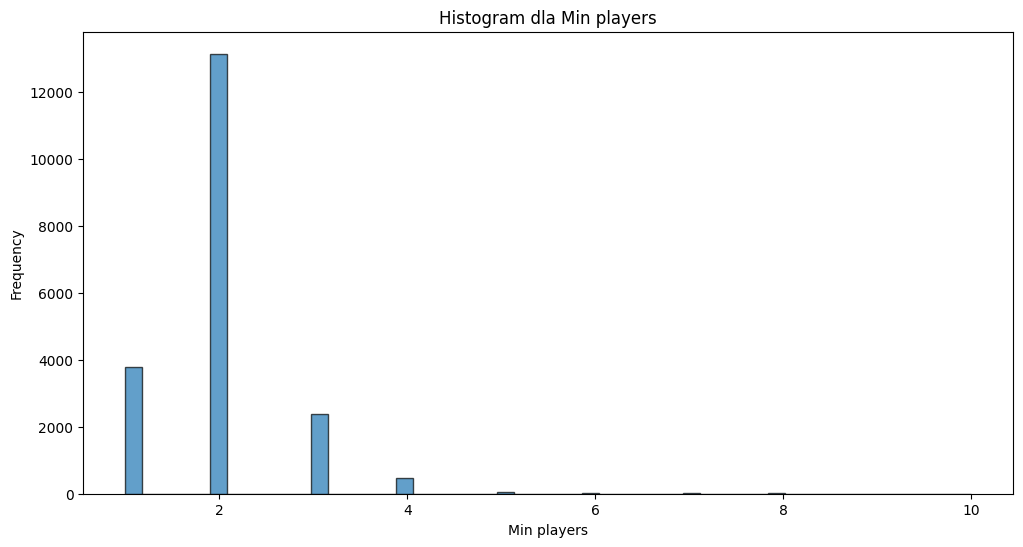

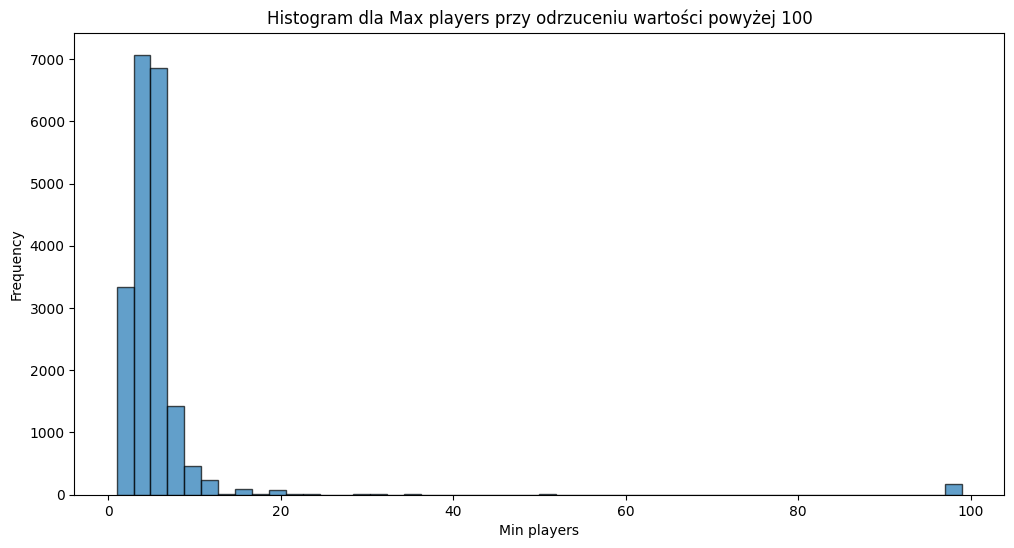

In [32]:

for col in ['Age', 'Min players']:
    plt.figure(figsize=(12, 6))
    plt.hist(data[col], bins=50, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram dla {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.show()

plt.figure(figsize=(12, 6))
plt.hist(data[data['Max players'] < 100]['Max players'], bins=50, edgecolor='black', alpha=0.7)
plt.title(f'Histogram dla Max players przy odrzuceniu wartości powyżej 100')
plt.xlabel(col)
plt.ylabel('Frequency')

plt.show()

Dla "Age" wyodrębniliśmy 3 garby zawierajace znaczną część punktów danych oraz ogony z lewej i prawej, dzielące zbiór na 5 koszy.

Age_category
7-8      5060
11-13    4914
9-10     4415
<7       2840
>13      2640
Name: count, dtype: int64


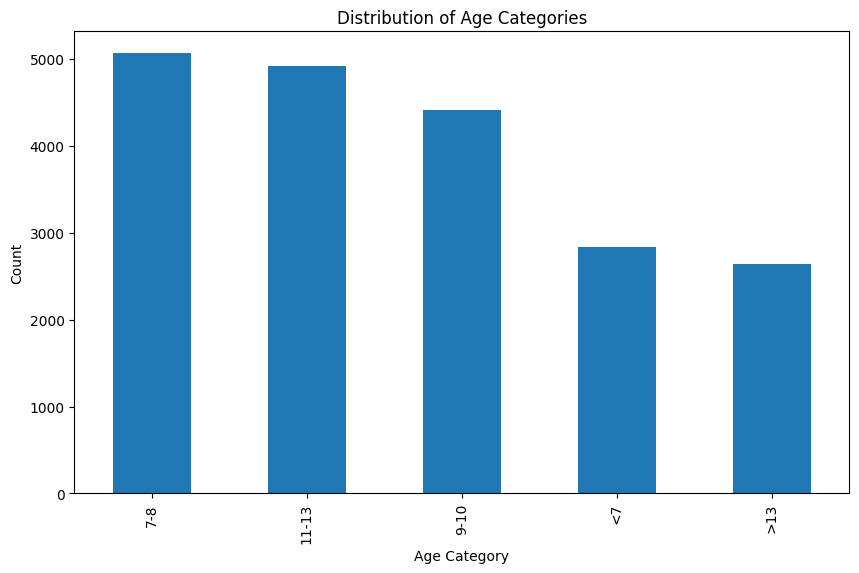

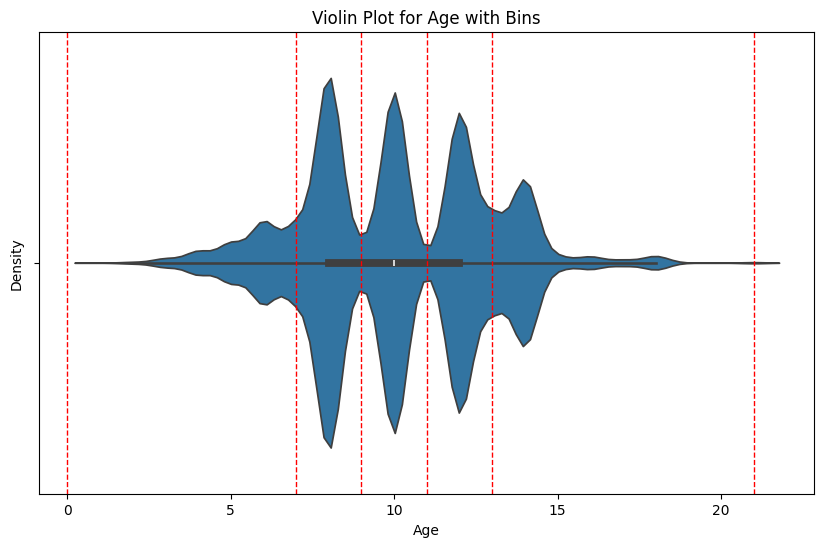

In [33]:
bins = [0, 7, 9, 11, 13, 21]
labels = ['<7', '7-8', '9-10', '11-13', '>13']

data['Age_category'] = pd.cut(data['Age'], bins=bins, labels=labels, include_lowest=True)

print(data['Age_category'].value_counts())

plt.figure(figsize=(10, 6))
data['Age_category'].value_counts().plot(kind='bar')
plt.title('Dystrybucja kategorii dla Age')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()


plt.figure(figsize=(10, 6))
sns.violinplot(x=data['Age'])
plt.title('Violin Plot dla Age z oznacznymi przedziełami podziału')
plt.xlabel('Age')
plt.ylabel('Density')

for boundary in bins:
    plt.axvline(boundary, color='red', linestyle='--', linewidth=1)

plt.show()

W przypadku "Max players" zdecydowaliśmy sie na zastosowanie koszy o różnej rozpiętości - mniejszej dla danych od 1 do 10 gdzie znajduje się większość rekordów, oraz o większej rozpiętości dla ogona zawierającego małą część wszystkich rekordów.

Max_players_category
4        6850
6        3807
5        3051
2        2992
8        1158
10        376
1         353
11-15     287
>20       287
7         268
3         219
16-20     142
9          79
Name: count, dtype: int64


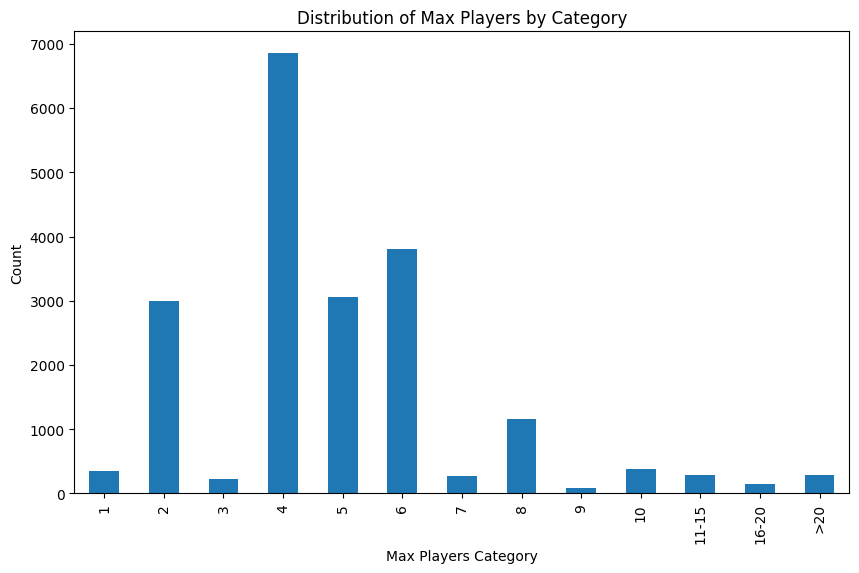

In [34]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-20', '>20']

data['Max_players_category'] = pd.cut(data['Max players'], bins=bins, labels=labels, include_lowest=True)

print(data['Max_players_category'].value_counts())

plt.figure(figsize=(10, 6))
data['Max_players_category'].value_counts().sort_index().plot(kind='bar')
plt.title('Dystrybucja kategorii Max Players')
plt.xlabel('Max Players Category')
plt.ylabel('Count')
plt.show()


Atrybut "Min players" zawiera w sobie wszystkie wartości od 1 do 10, więc zmieniliśmy jedynie typ kolumny na kategoryczną.

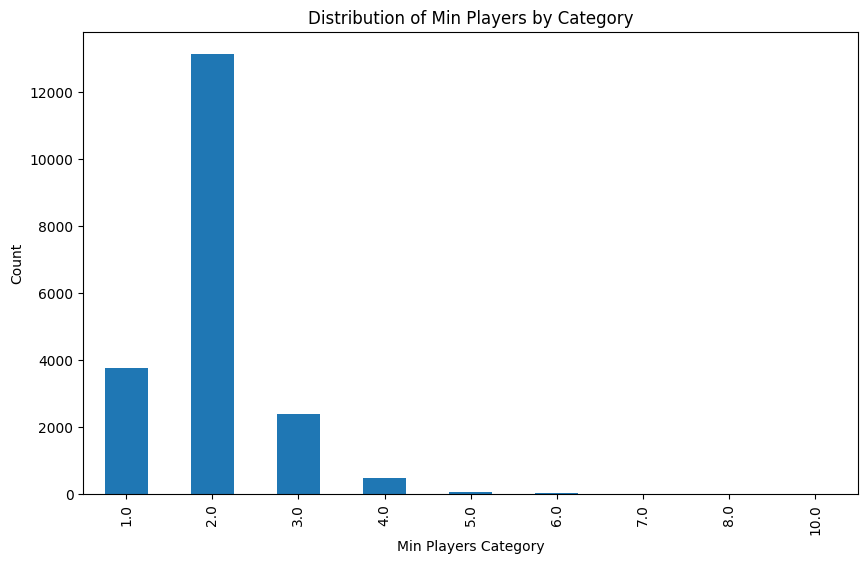

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

data['Min_players_category'] = data['Min players'].astype('category')

plt.figure(figsize=(10, 6))
data['Min_players_category'].value_counts().sort_index().plot(kind='bar')
plt.title('Dystrybucja kategorii Min Players')
plt.xlabel('Min Players Category')
plt.ylabel('Count')
plt.show()


Po przerobieniu tych kolumn na rangowe odrzucamy orginalne kolumny:

In [36]:
data = data.drop(["Age", "Max players", "Min players"], axis=1)

Histogramy po usunięciu wartości odstających prezentują się nastepująco:

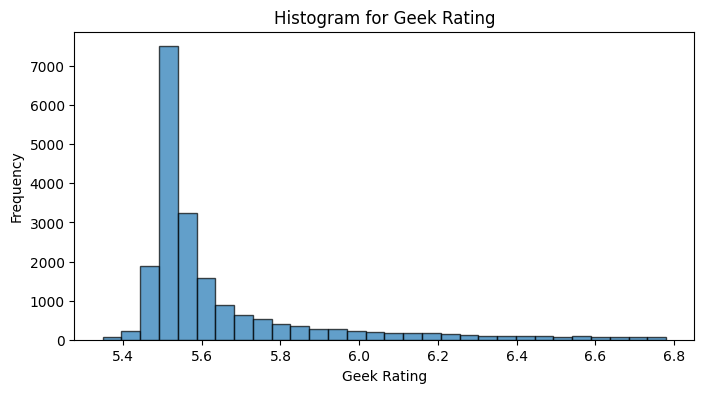

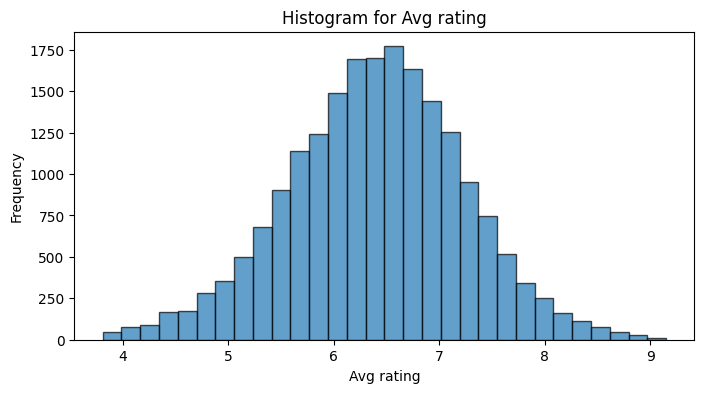

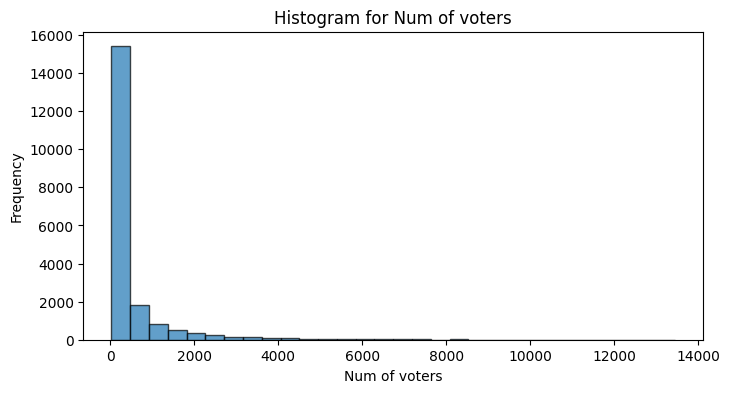

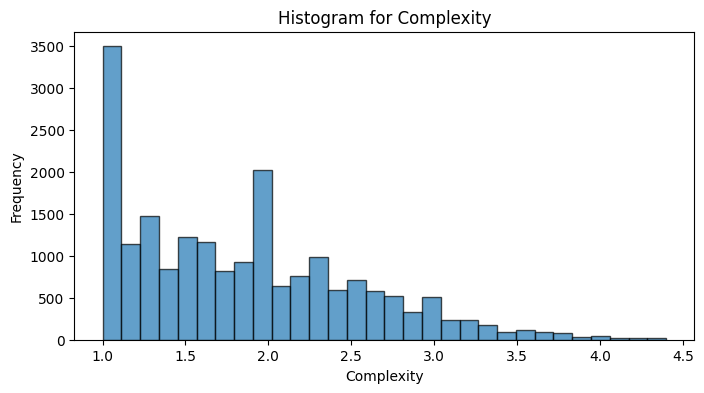

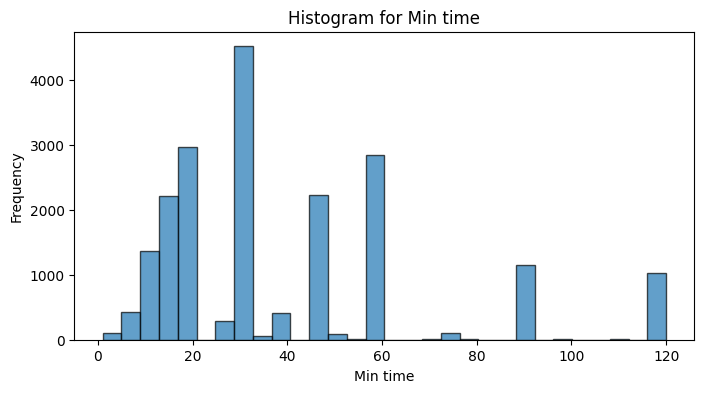

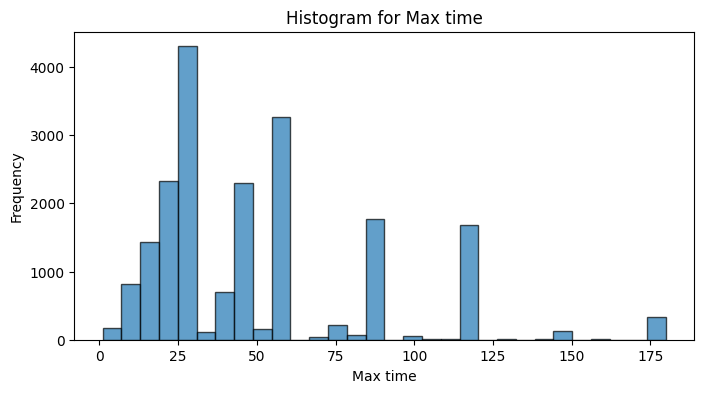

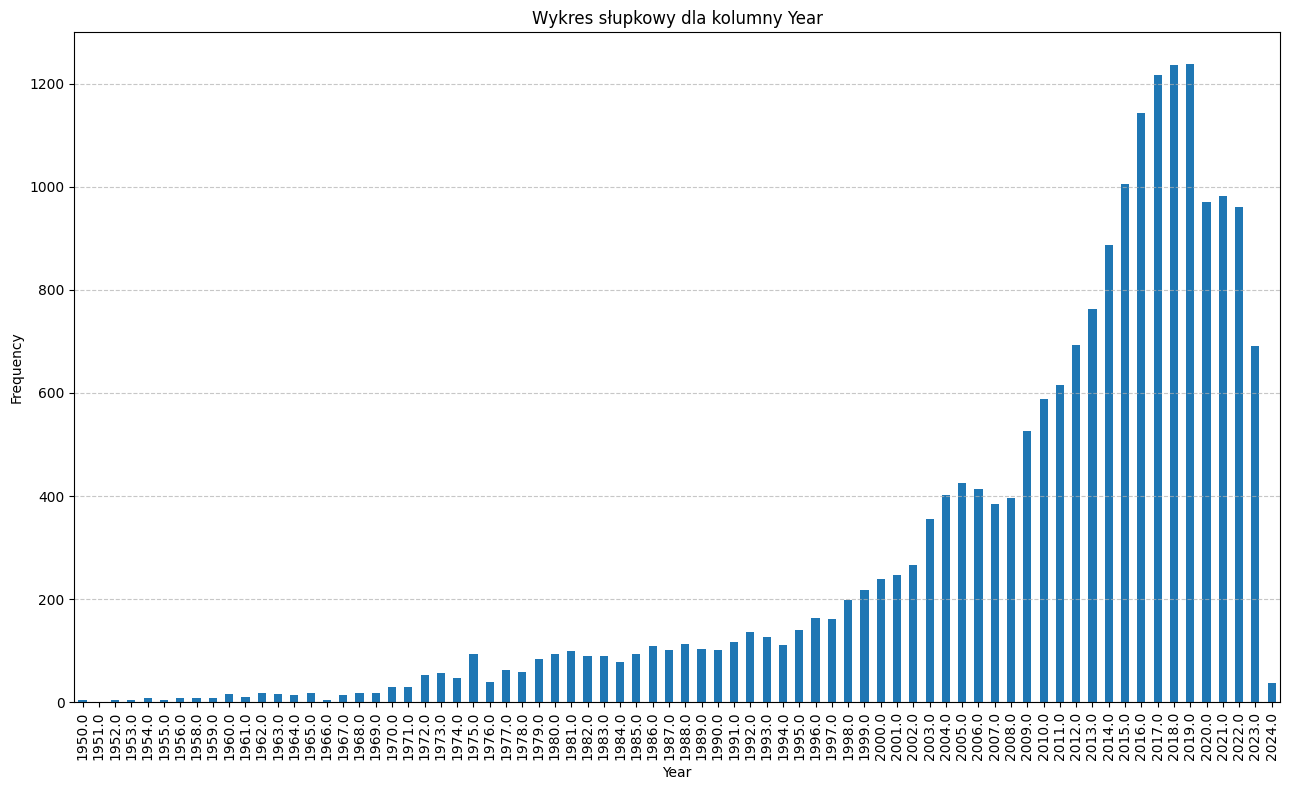

In [37]:

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if "Year" in numeric_columns:
    numeric_columns.remove("Year")

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(data[col], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram dla {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.show()

plt.figure(figsize=(13, 8))
value_counts = data['Year'].value_counts().sort_index()
value_counts.plot(kind='bar')
plt.title(f'Wykres słupkowy dla kolumny Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(value_counts.index)), labels=value_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, 706 to 25338
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Title                 19869 non-null  object  
 1   Geek Rating           19869 non-null  float64 
 2   Avg rating            19869 non-null  float64 
 3   Num of voters         19869 non-null  int64   
 4   Year                  19869 non-null  float64 
 5   Complexity            19869 non-null  float64 
 6   Min time              19869 non-null  float64 
 7   Max time              19869 non-null  float64 
 8   Type 1                9540 non-null   object  
 9   Age_category          19869 non-null  category
 10  Max_players_category  19869 non-null  category
 11  Min_players_category  19869 non-null  category
dtypes: category(3), float64(6), int64(1), object(2)
memory usage: 1.6+ MB


Ostatecznie po odsianiu wartości odstajacych w zbiorze zostało niecałe 20 tysięcy różnych gier.

# 3. Analiza relacji między zmiennymi

In [39]:

data_orginal = data_orginal.drop(columns=['Age'])
data_orginal = data_orginal.drop(columns=['Min players'])
data_orginal = data_orginal.drop(columns=['Max players'])
data_orginal = data_orginal.drop(columns=['Price'])

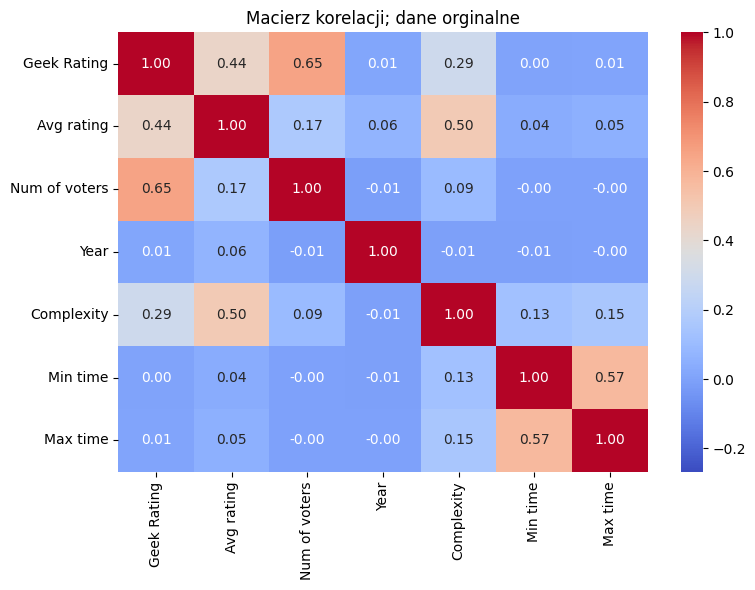

In [40]:
numeric_df_original = data_orginal.select_dtypes(include=['float64', 'int64'])
correlation_matrix_original = numeric_df_original.corr()
numeric_df_modified = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix_modified = numeric_df_modified.corr()

vmin = min(correlation_matrix_original.min().min(), correlation_matrix_modified.min().min())
vmax = max(correlation_matrix_original.max().max(), correlation_matrix_modified.max().max())

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_original, annot=True, cmap="coolwarm", fmt=".2f", vmin=vmin, vmax=vmax)
plt.title('Macierz korelacji; dane orginalne')
plt.tight_layout()
plt.show()

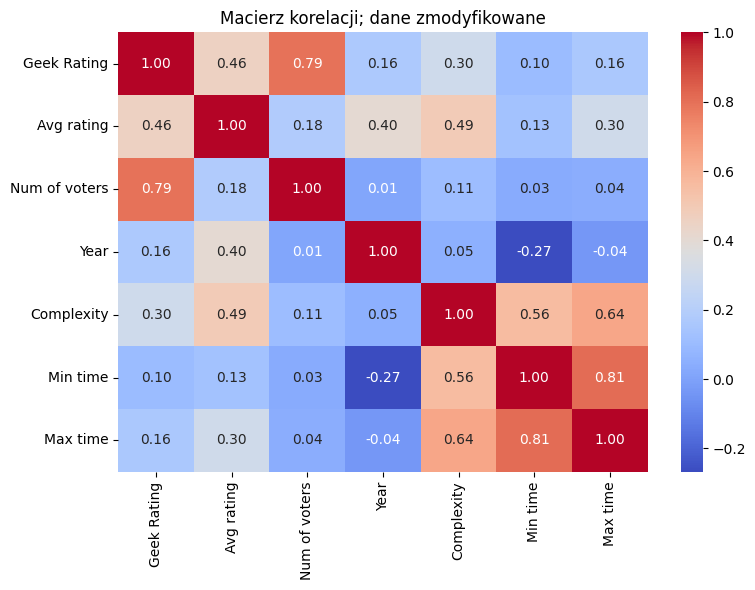

In [41]:


plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_modified, annot=True, cmap="coolwarm", fmt=".2f", vmin=vmin, vmax=vmax)
plt.title('Macierz korelacji; dane zmodyfikowane')
plt.tight_layout()
plt.show()


Jak widać powyżej, najbardziej skorelowanymi z sobą cechami są 'Min Time' oraz 'Min Time' z korelacją 0.81; uznaliśmy, że na tym etapie jest to jednak zbyt niska korelacja, by zdecydować się na odrzucenie jednej z nich. Innymi korelacjami, które warto wymienić, są 'Avg rating' oraz 'Geek Rating', 'Year' i 'Complexity'; 'Min time' 'Complexity'; a także 'Max time' oraz 'Complexity'. Najmniej skorelowanymi cechami są 'Num of voters' oraz 'Year'.

Z naszą cechą objaśnianą ('Num of voters') najbardziej skorelowany jest 'Geek Rating'. Pozostałe cechy wykazują niewielką korelację z nią.


Ogólnie można zauważyć, że po "oczyszczeniu" danych z wartości skrajnych dużo cech wykazuje korelację z innymi cechami.